In [1]:
import numpy as np
import roboticstoolbox as rtb
from roboticstoolbox import tools as rtb_tools
import matplotlib.pyplot as plt
from math import pi
from spatialmath import SE3

In [2]:
# 1. Инициализация робота Puma560
robot = rtb.models.DH.Puma560()

In [41]:
# 2. Задание начальной и конечной конфигураций
q_start = np.array([0, 0, 0, 0, 0, 0])
q_goal = np.array([pi/4, -pi/3, -pi/4, pi/3, -pi/3, pi/4], dtype=np.float64)
q_goal_pos = robot.fkine(q_goal).t 

In [54]:
# Начальная точка (слева)
T_start = SE3(0.6, -0.4, 0.3)  # X=-0.4, Y=0, Z=0.3

# Конечная точка (справа)
T_goal = SE3(-0.8, 0.4, 0.6)    # X=+0.4, Y=0, Z=0.3

q_start = robot.ikine_LM(T_start).q
q_goal = robot.ikine_LM(T_goal).q
q_goal_pos = robot.fkine(q_goal).t

In [55]:
# 3. Определение препятствий в рабочем пространстве
obstacles = [
    {'pos': [0.4, 0.2, 0.3], 'radius': 0.15},
    {'pos': [0.1, -0.3, 0.2], 'radius': 0.1},
    {'pos': [-0.2, 0.1, 0.4], 'radius': 0.12}
]

In [56]:
# 4. Параметры потенциального поля
eta_att = 0.5  # Коэффициент притяжения
eta_rep = 0.8  # Коэффициент отталкивания
rho_0 = 0.25   # Радиус влияния препятствий

def compute_potential(q):
    # Прямая кинематика для текущей конфигурации
    Te = robot.fkine(q)
    current_pos = Te.t
    
    # Притягивающий потенциал
    dist_to_goal = np.linalg.norm(current_pos - q_goal_pos)
    U_att = 0.5 * eta_att * dist_to_goal**2
    
    # Отталкивающий потенциал
    U_rep = 0
    for link in robot.links:
        T_link = robot.fkine(q, end=link.name)
        pos_link = T_link.t
        for obs in obstacles:
            dist = np.linalg.norm(pos_link - obs['pos'])
            if dist < obs['radius']:
                U_rep += 0.5 * eta_rep * (1/dist - 1/obs['radius'])**2
            elif dist < obs['radius'] + rho_0:
                U_rep += 0.5 * eta_rep * ((1/dist - 1/(obs['radius'] + rho_0))**2)
    
    return U_att + U_rep

In [57]:
# 5. Численное вычисление градиента
def compute_gradient(q, delta=1e-4):
    grad = np.zeros_like(q)
    for i in range(len(q)):
        q_plus = q.copy()
        q_plus[i] += delta
        q_minus = q.copy()
        q_minus[i] -= delta
        grad[i] = (compute_potential(q_plus) - compute_potential(q_minus)) / (2*delta)
    return grad

In [66]:
# 6. Планирование пути
current_q = q_start.copy().astype(np.float64)  # Гарантируем float64
path = [current_q.copy()]
max_iter = 2000
step_size = 0.01

for _ in range(max_iter):
    grad = compute_gradient(current_q)
    norm_grad = np.linalg.norm(grad)
    # Если градиент мал, добавьте случайное возмущение
    if norm_grad < 1e-3:
        grad += np.random.uniform(-0.05, 0.05, size=grad.shape)
    current_q = current_q - step_size * grad
    path.append(current_q.copy())
    if np.linalg.norm(current_q - q_goal) < 0.01:
        break

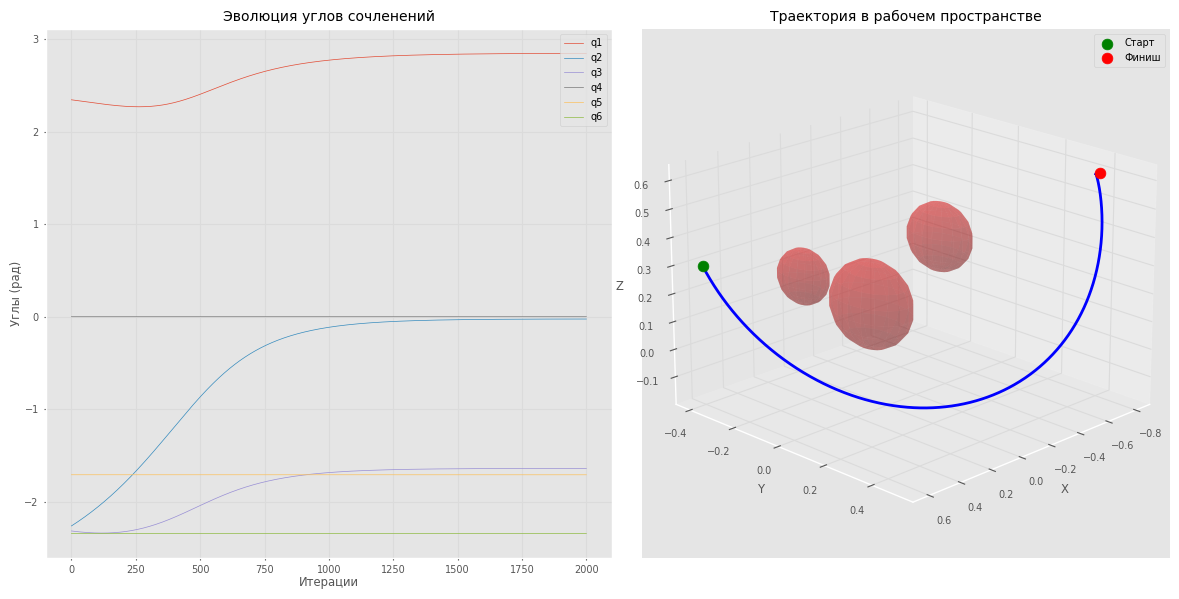

In [67]:
# 7. Визуализация результатов
fig = plt.figure(figsize=(12, 6))

# График в конфигурационном пространстве
ax1 = fig.add_subplot(121)
ax1.plot(np.array(path))
ax1.set_title('Эволюция углов сочленений')
ax1.set_xlabel('Итерации')
ax1.set_ylabel('Углы (рад)')
ax1.legend([f'q{i+1}' for i in range(6)])
ax1.grid(True)

# 3D визуализация траектории
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('Траектория в рабочем пространстве')

# Отображение препятствий
for obs in obstacles:
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = obs['radius']*np.cos(u)*np.sin(v) + obs['pos'][0]
    y = obs['radius']*np.sin(u)*np.sin(v) + obs['pos'][1]
    z = obs['radius']*np.cos(v) + obs['pos'][2]
    ax2.plot_surface(x, y, z, color='red', alpha=0.3)

# Траектория конечного эффектора
ee_path = [robot.fkine(q).t for q in path]
ee_path = np.array(ee_path)
ax2.plot(ee_path[:,0], ee_path[:,1], ee_path[:,2], 'b', linewidth=2)

ax2.scatter(T_start.t[0], T_start.t[1], T_start.t[2], color='green', s=60, label='Старт')

# Конечная точка (красная)
ax2.scatter(T_goal.t[0], T_goal.t[1], T_goal.t[2], color='red', s=60, label='Финиш')

ax2.legend()

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.view_init(elev=20, azim=45)
plt.tight_layout()
plt.show()